# `Практикум по программированию на языке Python`

## `Задание 1.5. Классификация изображений`.

#### Фамилия, имя: `Элиан Андрей`

Дата выдачи: <span style="color:red">__20 февраля__</span>.

Мягкий дедлайн: <span style="color:red">__2 марта 5:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

In [123]:
import random
import numpy as np
from typing import Optional, Tuple, Union, List

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms as T

import matplotlib_inline
import matplotlib.pyplot as plt

import time

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def check_numel(module: torch.nn.Module, params_numel: int, buffers_numel: Optional[int] = None) -> None:
    """Check whether module has correct number of parameters and buffers
    :param torch.nn.Module module: Target model
    :param int params_numel: Target number of parameters
    :param Optional[int] buffers_numel: Target number of buffers
    :rtype:
    """
    numel = sum(param.numel() for param in module.parameters())
    assert numel == params_numel, f'For params numel != correct numel: {numel} vs {params_numel}'

    if buffers_numel is not None:
        numel = sum(param.numel() for param in module.buffers())
        assert numel == buffers_numel, f'For buffers numel != correct numel: {numel} vs {buffers_numel}'

set_global_seed(42)

## `Задание 1. Загрузка данных (0.5 балла)`

В этой домашке работа с данными будет максимально простой. Мы скачаем `MNIST` с помощью [стандартных средств](https://pytorch.org/vision/0.8/datasets.html#mnist) торча. Посмотреть список других доступных датасетов можно [здесь](https://pytorch.org/vision/0.8/datasets.html).

In [3]:
def load_mnist(train, transform=None):
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

Пиксели изображений принимают значения [0,1]. Скачайте датасет и посчитайте выборочное среднее и выборочное стандартное отклонение для значения пикселя. Т.е. должно получиться число `mean` для среднего, и число `std` для стандартного отклонения.

*Подсказка:* Подумайте, на какой части датасета нужно считать эти статистики (обучение или валидация), чтобы предотвратить утечку данных.

*Подсказка:* У торч датасета реализован метод `__getitem__`, т.е. его можно индексировать `dataset[i]`.

In [11]:
dataset = load_mnist(train=True)
train = dataset.train_data

mean = train.div(255).mean()
std = train.div(255).std()
mean, std

(tensor(0.1307), tensor(0.3081))

Полученные значения можно применить для нормализации изображений, когда будем подавать их в нейросеть.

Нормализация данных в машинном обучении -- это процесс приведения числовых данных к единому масштабу, чтобы они находились в определённом диапазоне (например, от 0 до 1 или со средним 0 и стандартным отклонением 1). Это помогает улучшить скорость и стабильность обучения моделей, особенно когда признаки имеют разный масштаб.

In [12]:
norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_mnist = load_mnist(True, norm_transform)
val_mnist = load_mnist(False, norm_transform)

Во время обучения данные подаются в нейросеть батчами.

Обычно `batch_size` выбирается так, чтобы во время обучения получалась меньше дисперсия градиента (вы уже знакомы с sgd), также часто `batch_size` выбирается максимально возможным по ресурсам.

Для этой задачи нам хватит `batch_size = 64` во время обучения.

**Ответьте на вопрос:** Почему в большинстве задач для валидации и тестирования можно выбирать `batch_size` больше?

In [13]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True
)

val_mnist_loader = torch.utils.data.DataLoader(
    dataset=val_mnist,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False
)

In [14]:
images, labels = next(iter(train_mnist_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

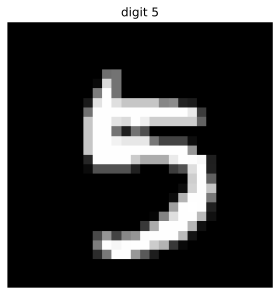

In [15]:
i = 3
plt.title(f'digit {labels[i]}')
plt.imshow(images[i, 0], cmap='gray')
plt.axis('off')
plt.show()

## `Задание 2. Цикл обучения (1.5 балла)`

Ниже предоставлен базовый вариант цикла обучения, представленный тремя функциями: `train_epoch`, `val_epoch`, `train_val`.

In [50]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""

    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        # 0. распакавываем данные на нужное устройство
        images, labels = images.to(device), labels.to(device) # YOUR CODE HERE

        # 1. сбрасываем градиенты предыдущего батча
        optimizer.zero_grad() # YOUR CODE HERE

        # 2. прогоняем данные через нашу нейросеть
        logits = network(images) # YOUR CODE HERE

        # 3. считаем loss
        loss = criterion(logits, labels).mean() # YOUR CODE HERE

        # 4. считаем градиенты
        loss.backward()

        # 5. обновляем параметры
        optimizer.step()

In [51]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        # 0. распакавываем данные на нужное устройство
        images, labels = images.to(device), labels.to(device) # YOUR CODE HERE

        # 1. прогоняем данные через нашу нейросеть
        logits = network(images) # YOUR CODE HERE

         # 2. получаем предсказание
        pred = torch.argmax(logits, dim=1) # YOUR CODE HERE

        # 3. логгируем лосс и accuracy
        val_loss += criterion(logits, labels).sum().item()
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

In [52]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""

    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        train_epoch(network, train_loader, criterion, optimizer)
        val_epoch(network, val_loader, criterion)

Для проверки, что все работает, обучите бейзлайн -- однослойную [полносвязную](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) сеть на [кросс-энтропийный лосс](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html).


*Заметьте*, что на вход этому лоссу нужно подавать сырой выход нейросети, а не результат применения софтмакса.

*Подсказка:* Не забудьте вытянуть картинку в вектор с помощью `torch.nn.Flatten()`.

In [56]:
class LogReg(nn.Module):
    def __init__(
        self,
        in_features,
        out_features
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(in_features, out_features));
        self.bias = nn.Parameter(torch.zeros(out_features));

    def forward(self, x):
        inp = torch.flatten(x, 1, -1)
        return (inp @ self.weight) + self.bias

In [57]:
net = LogReg(images.shape[2] * images.shape[3], 10)
check_numel(net, 7850)

In [58]:
optimizer = optim.SGD(
    net.parameters(), 
    lr=1
)

criterion = nn.CrossEntropyLoss()

train_val(net, 4, criterion, optimizer, train_mnist_loader, val_mnist_loader);

Test set: Avg. loss: 0.0394 Accuracy: 1129/10000 (11%)
Test set: Avg. loss: 0.0019 Accuracy: 8849/10000 (88%)
Test set: Avg. loss: 0.0025 Accuracy: 8442/10000 (84%)
Test set: Avg. loss: 0.0026 Accuracy: 8514/10000 (85%)
Test set: Avg. loss: 0.0020 Accuracy: 8698/10000 (87%)


## `Задание 3. Логирование (3 балл)`

Скопируйте и перепишите функции `train_epoch`, `val_epoch`, `train_val` таким образом, чтобы
- во время обучения раз в `logging_interval` шагов оптимизации выводились лосс и accuracy на одном батче (пример ниже, но не обязательно делать идентично)
- происходило сохранение весов лучшей (по accuracy на валидации) модели и состояния оптимизатора ([в помощь](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended))
- в конце обучения выводился и сохранялся график-саммари (пример ниже, но не обязательно делать идентично)

**Ответьте на вопрос:** Что хранится в состоянии оптимизатора? Зачем нужно его сохранять? Приведите хотя бы один пример оптимизатора, для которого есть смысл сохранять состояние.

In [158]:
# YOUR TRAINING FUNCTIONS HERE
def train_epoch_log(
    network,
    train_loader,
    criterion,
    optimizer,
    n_epoch
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""

    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout

    t_loss = []
    t_moments = []
    logging_interval = len(train_loader.dataset) // 3 - 300
    check_line = 0
    i_images = 0
    for images, labels in train_loader:
        # 0. распакавываем данные на нужное устройство
        images, labels = images.to(device), labels.to(device) # YOUR CODE HERE

        # 1. сбрасываем градиенты предыдущего батча
        optimizer.zero_grad() # YOUR CODE HERE

        # 2. прогоняем данные через нашу нейросеть
        logits = network(images) # YOUR CODE HERE

        # 3. считаем loss
        loss = criterion(logits, labels).mean() # YOUR CODE HERE

        # 4. считаем градиенты
        loss.backward()

        # 5. обновляем параметры
        optimizer.step()

        if i_images >= check_line:
            print(
                f'Train epoch: {n_epoch} ',
                f'[{i_images}/{len(train_loader.dataset)} ({100. * i_images / len(train_loader.dataset) : .0f}%)]\t',
                f'Loss: {loss}'
            )
            t_loss.append(loss.item())
            t_moments.append((i_images / len(train_loader.dataset) + n_epoch - 1) * 1.0)
            
            check_line += logging_interval
        i_images += images.shape[0]
    return (t_loss, t_moments)


@torch.no_grad()
def val_epoch_log(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        # 0. распакавываем данные на нужное устройство
        images, labels = images.to(device), labels.to(device) # YOUR CODE HERE

        # 1. прогоняем данные через нашу нейросеть
        logits = network(images) # YOUR CODE HERE

         # 2. получаем предсказание
        pred = torch.argmax(logits, dim=1) # YOUR CODE HERE

        # 3. логгируем лосс и accuracy
        val_loss += criterion(logits, labels).sum().item()
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

    return (val_loss, val_accur)


def train_val_log(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""

    train_loss = []
    train_moments = []
    val_loss = [-42 for i in range(n_epochs + 1)]
    val_accur = [-42 for i in range(n_epochs + 1)]
    start_time = time.time()
    times = []
    
    best_accur = 0
    
    val_loss[0], val_accur[0] = val_epoch_log(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        train_res = train_epoch_log(network, train_loader, criterion, optimizer, epoch)
        train_loss.extend(train_res[0])
        train_moments.extend(train_res[1])
        
        val_loss[epoch], val_accur[epoch] = val_epoch_log(network, val_loader, criterion)

        if best_accur < val_accur[epoch]:
            best_accur = val_accur[epoch]
            torch.save({
                        "net": network.state_dict(),
                        "optimizer": optimizer.state_dict()
                        }, ".\\best.pt")
    
    # Visualizing
    print(val_loss)
    fig, ax = plt.subplots(figsize=(9, 3))
    plt.plot(train_moments, train_loss, "o-", label="Train loss")
    plt.plot(torch.arange(0, n_epochs + 1), val_loss, "o-", label="Val loss")
    plt.xlabel("epochs completed")
    plt.ylabel("loss")
    plt.legend()
    plt.grid()
    plt.show()

Test set: Avg. loss: 0.0364 Accuracy: 1197/10000 (12%)
Train epoch: 1  [0/60000 ( 0%)]	 Loss: 34.0892219543457
Train epoch: 1  [19712/60000 ( 33%)]	 Loss: 3.4412827491760254
Train epoch: 1  [39424/60000 ( 66%)]	 Loss: 1.0428698062896729
Train epoch: 1  [59136/60000 ( 99%)]	 Loss: 0.6143622398376465
Test set: Avg. loss: 0.0021 Accuracy: 8713/10000 (87%)
Train epoch: 2  [0/60000 ( 0%)]	 Loss: 1.6916638612747192
Train epoch: 2  [19712/60000 ( 33%)]	 Loss: 3.0575122833251953
Train epoch: 2  [39424/60000 ( 66%)]	 Loss: 1.8771159648895264
Train epoch: 2  [59136/60000 ( 99%)]	 Loss: 1.3895273208618164
Test set: Avg. loss: 0.0020 Accuracy: 8768/10000 (88%)
Train epoch: 3  [0/60000 ( 0%)]	 Loss: 2.7606749534606934
Train epoch: 3  [19712/60000 ( 33%)]	 Loss: 2.7944817543029785
Train epoch: 3  [39424/60000 ( 66%)]	 Loss: 0.2761634290218353
Train epoch: 3  [59136/60000 ( 99%)]	 Loss: 1.6103050708770752
Test set: Avg. loss: 0.0017 Accuracy: 8902/10000 (89%)
Train epoch: 4  [0/60000 ( 0%)]	 Loss: 1.

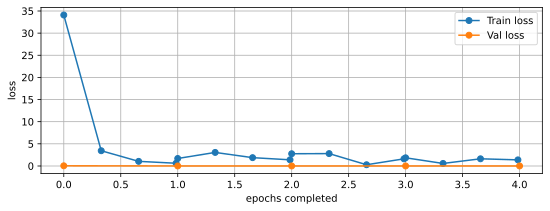

In [160]:
class LogReg_log(nn.Module):
    def __init__(
        self,
        in_features,
        out_features
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(in_features, out_features));
        self.bias = nn.Parameter(torch.zeros(out_features));

    def forward(self, x):
        inp = torch.flatten(x, 1, -1)
        return (inp @ self.weight) + self.bias


net = LogReg_log(images.shape[2] * images.shape[3], 10)
check_numel(net, 7850)

optimizer = optim.SGD(
    net.parameters(), 
    lr=1
)

criterion = nn.CrossEntropyLoss()

train_val_log(net, 4, criterion, optimizer, train_mnist_loader, val_mnist_loader);


Validation set: Avg. loss: 2.3681, Accuracy: 1300/10000 (13%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.399217
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.316934
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.522537
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.435730

Validation set: Avg. loss: 0.2926, Accuracy: 9185/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.236281
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.288449
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.384067
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.204619

Validation set: Avg. loss: 0.2779, Accuracy: 9231/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.410723
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.264276
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.317687
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.088601

Validation set: Avg. loss: 0.2833, Accuracy: 9208/10000 (92%)



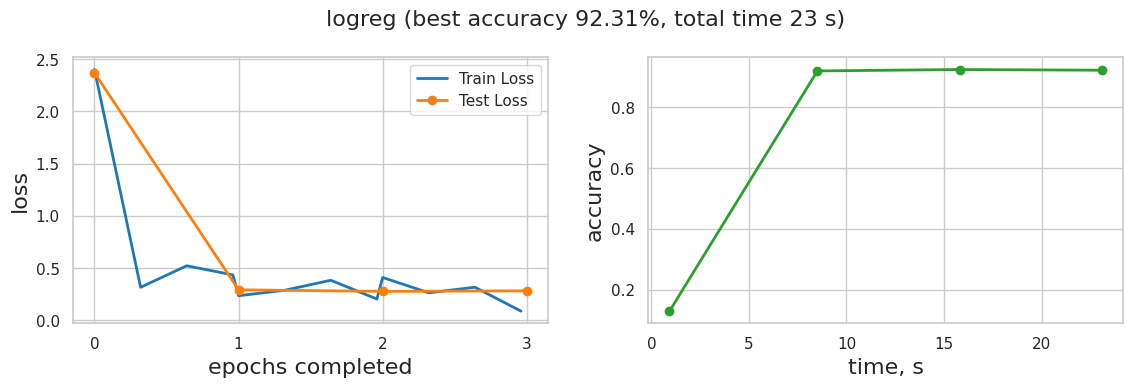

In [ ]:
# YOUR CODE HERE

Загрузите лучшие веса модели и подсчитайте accuracy на валидации, чтобы подтвердить что веса сохранились корректно.

In [127]:
# YOUR CODE HERE
best_model = torch.load(".\\best.pt", weights_only=True)
net.load_state_dict(best_model["net"])

net.eval()
val_epoch_log(net, val_mnist_loader, criterion)

Test set: Avg. loss: 0.0017 Accuracy: 8899/10000 (89%)


(0.0017442184269428253, 0.8899)

Загрузите сохранённое состояние оптимизатора и сделайте две эпохи обучения, чтобы подтвердить, что состояния оптимизатора были сохранены корректно.

Test set: Avg. loss: 0.0016 Accuracy: 9008/10000 (90%)
Train epoch: 1  [0/60000 ( 0%)]	 Loss: 3.733858346939087
Train epoch: 1  [19712/60000 ( 33%)]	 Loss: 2.8172457218170166
Train epoch: 1  [39424/60000 ( 66%)]	 Loss: 1.2994303703308105
Train epoch: 1  [59136/60000 ( 99%)]	 Loss: 2.581383228302002
Test set: Avg. loss: 0.0018 Accuracy: 8895/10000 (89%)
Train epoch: 2  [0/60000 ( 0%)]	 Loss: 1.2432241439819336
Train epoch: 2  [19712/60000 ( 33%)]	 Loss: 2.839989185333252
Train epoch: 2  [39424/60000 ( 66%)]	 Loss: 1.6459147930145264
Train epoch: 2  [59136/60000 ( 99%)]	 Loss: 2.3817267417907715
Test set: Avg. loss: 0.0019 Accuracy: 8859/10000 (89%)
[0.0015848473221063615, 0.0018446236610412598, 0.0018545548915863037]


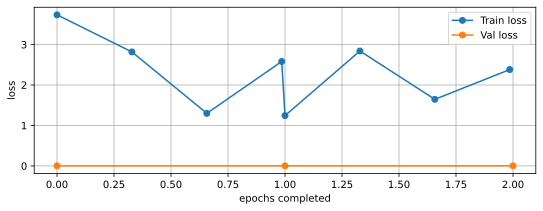

In [159]:
# YOUR CODE HERE
optimizer.load_state_dict(best_model["optimizer"])
train_val_log(net, 2, criterion, optimizer, train_mnist_loader, val_mnist_loader)

## `Задание 4. Логирование с помощью tensorboard (1 балл)`

На самом деле это дурной тон логировать обучение нейросети так, как это сделали вы выше. Дело в том, что весь функционал уже реализован в [`tensorboard`](https://pytorch.org/docs/stable/tensorboard.html), а вы написали велосипед.

In [ ]:
# ! pip3 install tensorboard
from torch.utils.tensorboard import SummaryWriter

Если у вас есть доступ к терминалу и браузеру, то удобнее всего ввести команду
```bash
tensorboard --logdir .
```
и открыть UI в выделенном локалхосте.

Если вы работаете в гугл колабе, то можете запустить UI как виджет в Jupyter:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .

Как только вы начнете логировать в объект типа `SummaryWriter`, в UI начнут строиться кривые обучения.

Скопируйте и перепишите функции обучения таким образом, чтобы логирование происходило в `tensorboard`.

*Замечание.* Вам пригодится метод `add_scalar`, чтобы сохранять лосс и accuracy, и метод `add_hparams`, чтобы сохранить важные гиперпараметры (например, кодовое имя архитектуры сети) и финальное достигнутое качество.

In [ ]:
# YOUR TRAINING FUNCTIONS HERE

## `Задание 5. Побейте бейзлайн (2+2 балла)`

На датасете [`CIFAR-10`](https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.CIFAR10) обучите модель, которая выдает accuracy `>=0.7` (2 балла) и accuracy `>=0.8` (ещё 2 балла).
- Можете использовать любые модули `pytorch`, любые оптимизаторы и шедулеры, можете использовать аугментации ([например](https://pytorch.org/vision/stable/transforms.html))
- Для отслеживания экспериментов используйте логирование с `tensorboard`, не забывайте давать осмысленные имена эспериментам и логировать нужные гиперпараметры, сохранять веса сети и состояние оптимизатора.

In [143]:
# YOUR CODE HERE
def load_cifar(train, transform=None):
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.CIFAR10(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

In [157]:
train_cifar = load_cifar(True, norm_transform)
val_cifar = load_cifar(False, norm_transform)

100.0%


In [178]:
# Объекты данных из обучающей выборки (50 000 цветных картинок размера 32 x 32).
x_train = torch.tensor(train_cifar.data) / 255.
y_train = torch.tensor(train_cifar.targets)

# Аналогично записываем x и y для валидационной выборки (10 000 примеров).
x_val = torch.tensor(val_cifar.data) / 255.
y_val = torch.tensor(val_cifar.targets)

In [171]:
images, labels = next(iter(train_cifar_loader))
images.shape, labels.shape, len(iter(train_cifar_loader))

(torch.Size([64, 3, 32, 32]), torch.Size([64]), 781)

In [179]:
class ResidualBlock(torch.nn.Module):  
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.ReLU,  # Класс функции активации.
    ):
        super().__init__()
        
        # Функция активации для нелинейности.
        self.activation = activation()
        
        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        #  (считаем, что размер ядра всегда нечётный).
        padding_size = (kernel_size - 1) // 2
        
        # Операция свёртки.
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode="zeros",
        )
        
        # Если числа каналов у входа и выхода различаются,
        #  то будем делать свёртку с ядром размера 1.
        if input_c != output_c:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.
    
    # Прямой проход.
    def forward(self, x):
        return self.activation(self.conv(x) + self.correct_channels(x))

IMG_SIZE = 32

class ResidualModel(torch.nn.Module):
    def __init__(
        self,
        out_size,                    # Число классов.
        residual_sizes,              # Задаём список троек: количество residual-блоков,
                                     #  число каналов и размер ядра в каждом таком блоке.
        linear_sizes,                # Список размеров линейных слоёв в финальном классификаторе.
        activation = torch.nn.ReLU,  # Какую функцию активации использовать.
        flatten = True,              # Использовать Flatten или GlobalPooling.
    ):
        super().__init__()
        self.flatten = flatten
        
        # Собираем все свёрточные слои в один блок.
        conv_layers = []

        current_c = 3
        for group_index, (num_residual, out_channels, kernel_size) in enumerate(residual_sizes):
            for residual_index in range(num_residual):
                conv_layers.append(( 
                    # Добавляем несколько residual-блоков для каждой группы.
                    f"residual_{group_index}_{residual_index}",
                    ResidualBlock(
                        input_c = current_c if residual_index == 0 else out_channels,
                        output_c = out_channels,
                        kernel_size = kernel_size,
                        activation = activation,
                    ),
                ))
            current_c = out_channels
            if group_index < len(residual_sizes) - 1:
                conv_layers.append((
                    # В конце группы добавляем один pooling-слой,
                    # если это не последняя группа.
                    f"pooling_{group_index}",
                    torch.nn.AvgPool2d(2),
                ))
        
        self.conv_part = torch.nn.Sequential(OrderedDict(conv_layers))
        
        # Собираем все линейные слои во второй блок.
        out_c = residual_sizes[-1][1]
        final_size = IMG_SIZE // 2 ** (len(residual_sizes) - 1)
        clf_in_size = (out_c * final_size**2) if flatten else out_c
        
        linear_sizes = [clf_in_size, *linear_sizes, out_size]
        
        clf_layers = []
        
        for i, (from_size, to_size) in enumerate(zip(linear_sizes[:-1], linear_sizes[1:])):
            clf_layers.append((f"linear_{i}", torch.nn.Linear(from_size, to_size)))
            if i < len(linear_sizes) - 2:
                clf_layers.append((f"act_{i}", activation()))
            else:
                clf_layers.append(("log_softmax", torch.nn.LogSoftmax(-1)))
                
        self.clf_part = torch.nn.Sequential(OrderedDict(clf_layers))
    
    def forward(self, x):  # input (bs x h x w x c_in)
        x = x.permute((0, 3, 1, 2))  # (bs x c_in x h x w)
        
        x = self.conv_part(x)  # bs x c_out x h' x w'
        
        if self.flatten:
            # Операция Flatten.
            x = x.reshape(x.shape[0], -1)  # bs x (c_out * h' * w')
        else:
            # Операция GlobalMaxPooling.
            x = x.max(-1).values.max(-1).values  # bs x c_out

        
        x = self.clf_part(x)  # bs x 10
        
        return x

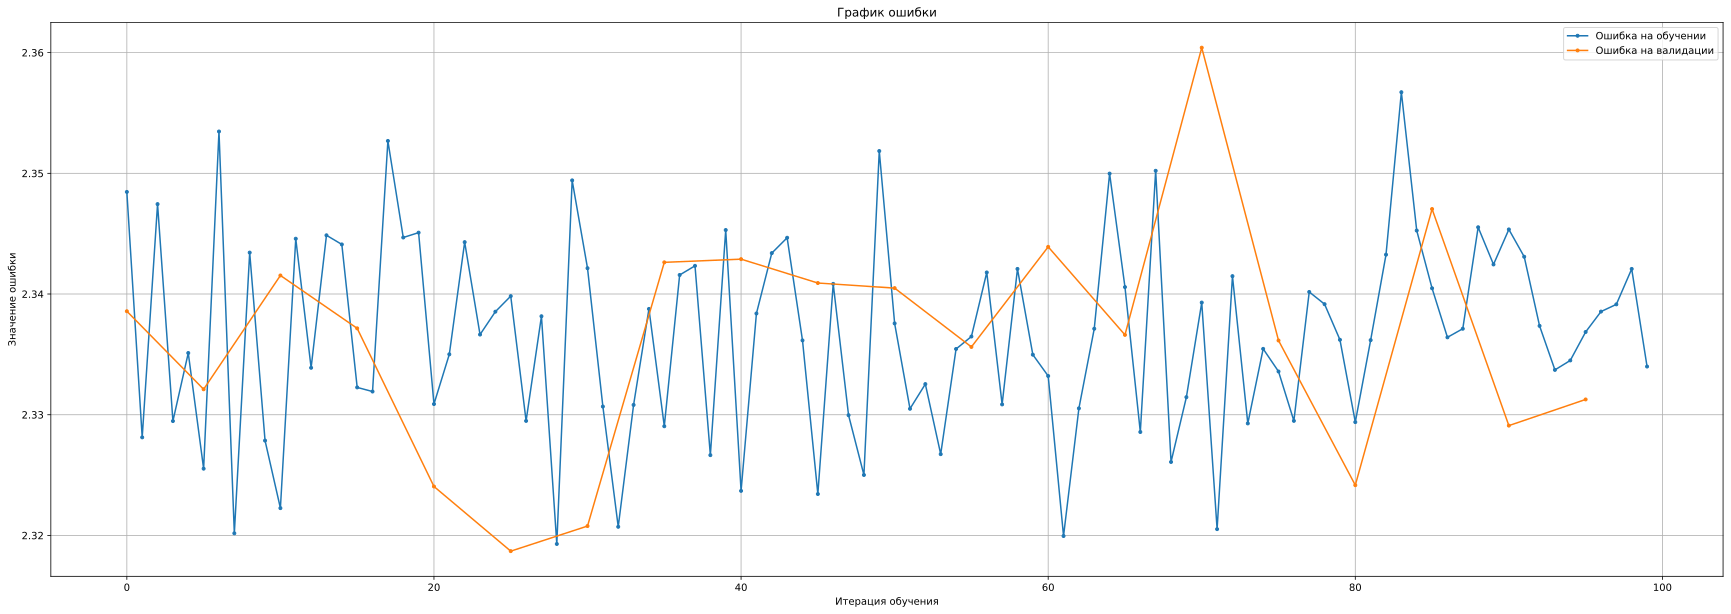

In [ ]:
from collections import OrderedDict
from IPython.display import clear_output

num_epochs = 5000
batch_size = 1000
val_every = 5

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=nn.ReLU,
    flatten=False,
)

opt = optim.SGD(
    net_cifar.parameters(),
    lr=1e-2
)

crit = nn.ReLU()

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Будем на каждой итерации обучения брать не все 50 000 картинок,
    #  а лишь случайные batch_size из них.
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])
    
    pred = model(x_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))
    
    loss.backward()
    optimizer.step()
    
    losses["train"].append(loss.item())
    
    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())
        
    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()
    
    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

## `Бонус. Побейте бейзлайн (3 балла)`

На датасете `CIFAR-10` обучите модель, которая выдает accuracy `>=0.9`.

In [ ]:
# YOUR CODE HERE